<a href="https://colab.research.google.com/github/hamidzangiabadi/sailfish-optimization-algorithm/blob/main/Method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ucimlrepo
!pip install mealpy
!pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.3/386.3 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 24.4 MB/s eta 0:00:00


# import datasets

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
wine = fetch_ucirepo(id=109)
breast_cancer = fetch_ucirepo(id=14)
zoo = fetch_ucirepo(id=111)


Datasets = [{ "name" : "Breast Cancer" , "dataset" : breast_cancer },{ "name" : "Zoo" , "dataset" : zoo },{ "name" : "Wine" , "dataset" : wine }]

## modify datasets and required information





Preprocessing to convert non int and float columns using label encoder

In [ ]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd



for x in Datasets:

  label_encoder = LabelEncoder()
  df = x["dataset"].data.features
  object_columns = df.select_dtypes(include=['object']).columns
  # Apply LabelEncoder to each object column
  for column in object_columns:
      df[column + '_encoded'] = label_encoder.fit_transform(df[column])
  df = df.drop(columns=object_columns)

  x["dataset"].data.features = df

  targetdf = x["dataset"].data.targets
  object_columns = targetdf.select_dtypes(include=['object']).columns
  # Apply LabelEncoder to each object column
  for column in object_columns:
      targetdf[column + '_encoded'] = label_encoder.fit_transform(targetdf[column])
  targetdf = targetdf.drop(columns=object_columns)

  x["dataset"].data.targets = targetdf


<ipython-input-59-01449c7003ef>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targetdf[column + '_encoded'] = label_encoder.fit_transform(targetdf[column])


## functions

In [ ]:
def binary_conversion(X, dim):
    Xbin = np.zeros(dim)
    for d in range(dim):
        if X[d] > 0.5:
            Xbin[d] = 1
        else:
            Xbin[d] = 0

    return Xbin



## method

In [ ]:
import numpy as np
from mealpy import FloatVar, GA,SFO
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing


def checkAccuracy(features):
    max_feat = len(features)
    num_feat = np.sum(binary_conversion(features,num_features) == 1)
    if num_feat == 0:
        return 1

    targets = np.array(y).ravel()
    selected_features = binary_conversion(features,num_features);
    f =  X.iloc[:, selected_features == 1]
    X_train, X_test, y_train, y_test = train_test_split(f, targets, test_size=0.3)
    svm = SVC(kernel='linear')
    svm.fit(X_train, y_train)
    # Predict on test set
    y_pred = svm.predict(X_test)

    num_valid = np.size(X_test, 0)
    yvalid  = y_test.reshape(num_valid)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

def objective_function(features):
    max_feat = len(features)
    num_feat = np.sum(binary_conversion(features,num_features) == 1)
    if num_feat == 0:
        return 1

    alpha = 0.6
    beta = 0.4

    targets = np.array(y).ravel()
    selected_features = binary_conversion(features,num_features);

    f =  X.iloc[:, selected_features == 1]
    X_train, X_test, y_train, y_test = train_test_split(f, targets, test_size=0.3)

    svm = SVC(kernel='linear')
    svm.fit(X_train, y_train)
    # Predict on test set
    y_pred = svm.predict(X_test)

    num_valid = np.size(X_test, 0)
    yvalid  = y_test.reshape(num_valid)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    acc     = np.sum(yvalid == y_pred) / num_valid
    error   = 1 - acc


    cost  = (alpha * error) + ( beta * (num_feat / max_feat))

    return cost


for dataset in Datasets:
  X = dataset["dataset"].data.features
  y = dataset["dataset"].data.targets

  num_features = X.shape[1]
  search_space = np.array([0, 1] * num_features)

  lb = np.zeros(num_features)
  ub = np.ones(num_features)


  problem_dict = {
    "bounds": FloatVar(lb=lb, ub=ub, ),
    "obj_func": objective_function,
    "minmax": "min",
  }

  model = GA.BaseGA(epoch=2,pop_size=10,pc=0.9, pm=0.05)
  g_best = model.solve(problem_dict)
  selectedFeaturesSubset = binary_conversion(g_best.solution,num_features)
  featuresCount = int(sum(selectedFeaturesSubset))
  dataset["FeaturesNo_GA"] = str(featuresCount)
  dataset["Accuracy_GA"] = str(checkAccuracy(selectedFeaturesSubset))

  print(f"Solution: {str(selectedFeaturesSubset)}, Fitness: {g_best.target.fitness}")
  print(f"No of features: {str(featuresCount)}")
  print(f"Reached accuracy: {str(checkAccuracy(selectedFeaturesSubset))}");



  model1 = SFO.OriginalSFO(epoch=3, pop_size=10, pp = 0.2, AP = 4.0, epsilon = 0.0001)
  g_best = model1.solve(problem_dict)
  selectedFeaturesSubset = binary_conversion(g_best.solution,num_features)
  featuresCount = int(sum(selectedFeaturesSubset))
  print(f"Solution: {binary_conversion(g_best.solution,num_features)}, Fitness: {g_best.target.fitness}")
  print(f"No of features: {str(featuresCount)}")
  print(f"Reached accuracy: {str(checkAccuracy(selectedFeaturesSubset))}");
  dataset["FeaturesNo_SFO"] = str(featuresCount)
  dataset["Accuracy_SFO"] = str(checkAccuracy(selectedFeaturesSubset))





INFO:mealpy.evolutionary_based.GA.BaseGA:Solving single objective optimization problem.
INFO:mealpy.evolutionary_based.GA.BaseGA:>>>Problem: P, Epoch: 1, Current best: 0.2493540051679587, Global best: 0.2493540051679587, Runtime: 0.09187 seconds
INFO:mealpy.evolutionary_based.GA.BaseGA:>>>Problem: P, Epoch: 2, Current best: 0.21886304909560722, Global best: 0.21886304909560722, Runtime: 0.10421 seconds
INFO:mealpy.swarm_based.SFO.OriginalSFO:Solving single objective optimization problem.


Solution: [0. 0. 1. 0. 0. 0. 0. 0. 0.], Fitness: 0.21886304909560722
No of features: 1
Reached accuracy: 0.7209302325581395


INFO:mealpy.swarm_based.SFO.OriginalSFO:>>>Problem: P, Epoch: 1, Current best: 0.21188630490956076, Global best: 0.21188630490956076, Runtime: 0.64685 seconds
INFO:mealpy.swarm_based.SFO.OriginalSFO:>>>Problem: P, Epoch: 2, Current best: 0.21188630490956076, Global best: 0.21188630490956076, Runtime: 0.65061 seconds
INFO:mealpy.swarm_based.SFO.OriginalSFO:>>>Problem: P, Epoch: 3, Current best: 0.17700258397932814, Global best: 0.17700258397932814, Runtime: 0.55387 seconds
INFO:mealpy.evolutionary_based.GA.BaseGA:Solving single objective optimization problem.
INFO:mealpy.evolutionary_based.GA.BaseGA:>>>Problem: P, Epoch: 1, Current best: 0.16370967741935488, Global best: 0.16370967741935488, Runtime: 0.07545 seconds


Solution: [0. 0. 0. 0. 0. 0. 0. 1. 0.], Fitness: 0.17700258397932814
No of features: 1
Reached accuracy: 0.7325581395348837


INFO:mealpy.evolutionary_based.GA.BaseGA:>>>Problem: P, Epoch: 2, Current best: 0.16370967741935488, Global best: 0.16370967741935488, Runtime: 0.08047 seconds
INFO:mealpy.swarm_based.SFO.OriginalSFO:Solving single objective optimization problem.


Solution: [0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1.], Fitness: 0.16370967741935488
No of features: 5
Reached accuracy: 0.8387096774193549


INFO:mealpy.swarm_based.SFO.OriginalSFO:>>>Problem: P, Epoch: 1, Current best: 0.13870967741935486, Global best: 0.13870967741935486, Runtime: 0.27008 seconds
INFO:mealpy.swarm_based.SFO.OriginalSFO:>>>Problem: P, Epoch: 2, Current best: 0.13870967741935486, Global best: 0.13870967741935486, Runtime: 0.28986 seconds
INFO:mealpy.swarm_based.SFO.OriginalSFO:>>>Problem: P, Epoch: 3, Current best: 0.13870967741935486, Global best: 0.13870967741935486, Runtime: 0.26175 seconds


Solution: [1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0.], Fitness: 0.13870967741935486
No of features: 4
Reached accuracy: 0.7741935483870968


INFO:mealpy.evolutionary_based.GA.BaseGA:Solving single objective optimization problem.
INFO:mealpy.evolutionary_based.GA.BaseGA:>>>Problem: P, Epoch: 1, Current best: 0.1897435897435898, Global best: 0.1897435897435898, Runtime: 1.14947 seconds
INFO:mealpy.evolutionary_based.GA.BaseGA:>>>Problem: P, Epoch: 2, Current best: 0.1871794871794872, Global best: 0.1871794871794872, Runtime: 1.52001 seconds
INFO:mealpy.swarm_based.SFO.OriginalSFO:Solving single objective optimization problem.


Solution: [0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0.], Fitness: 0.1871794871794872
No of features: 5
Reached accuracy: 0.8888888888888888


INFO:mealpy.swarm_based.SFO.OriginalSFO:>>>Problem: P, Epoch: 1, Current best: 0.11709401709401707, Global best: 0.11709401709401707, Runtime: 6.20381 seconds
INFO:mealpy.swarm_based.SFO.OriginalSFO:>>>Problem: P, Epoch: 2, Current best: 0.11709401709401707, Global best: 0.11709401709401707, Runtime: 3.59972 seconds
INFO:mealpy.swarm_based.SFO.OriginalSFO:>>>Problem: P, Epoch: 3, Current best: 0.11709401709401707, Global best: 0.11709401709401707, Runtime: 3.34287 seconds


Solution: [1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.], Fitness: 0.11709401709401707
No of features: 2
Reached accuracy: 0.8703703703703703


# create plots

[75.5813953488372, 80.64516129032258, 94.44444444444444]


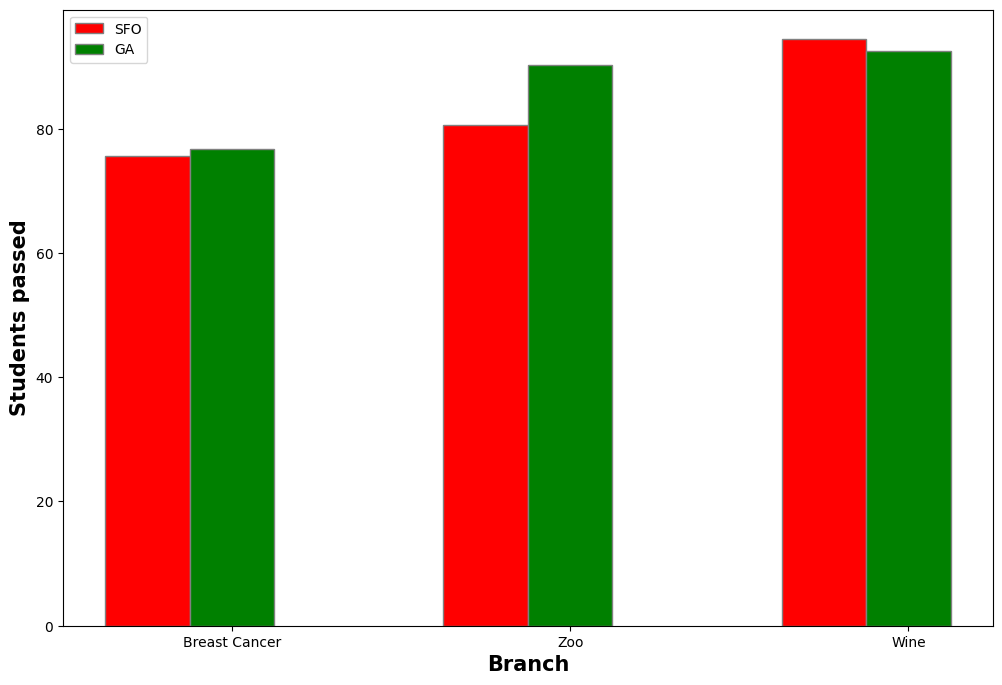

In [ ]:

import numpy as np
import matplotlib.pyplot as plt



# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))


SFO = [];
GA = [];

DatasetsName = []


for x in Datasets:
  SFO.append(float(x["Accuracy_SFO"]) * 100)
  GA.append(float(x["Accuracy_GA"]) * 100)
  DatasetsName.append(x["name"])


# Set position of bar on X axis
br1 = np.arange(len(SFO))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

# Make the plot
plt.bar(br1, SFO, color ='r', width = barWidth,
        edgecolor ='grey', label ='SFO')
plt.bar(br2, GA, color ='g', width = barWidth,
        edgecolor ='grey', label ='GA')

# Adding Xticks
plt.xlabel('Branch', fontweight ='bold', fontsize = 15)
plt.ylabel('Students passed', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(SFO))],
       DatasetsName)

plt.legend()
plt.show()